In [2]:
!pip install modal-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 1.8 MB/s eta 0:00:00 0:00:01


In [3]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.4 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 14.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer,

In [72]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling, classifier_uncertainty
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# **make cifar-10 imbalanced**

In [73]:
import numpy as np
from keras.datasets import mnist, cifar10

def remove_samples(dataset, labels,classes_to_remove, num_samples_to_keep):
    filtered_indices = []
    
    for i in range(len(classes_to_remove)):
        class_indices = np.where(labels == classes_to_remove[i])[0]
        print("class len " , len(class_indices))
        num_samples_keep = (len(class_indices) * num_samples_to_keep[i])
        print("samples " , num_samples_keep)
        keeped_indices = np.random.choice(class_indices, size=int(num_samples_keep), replace=False)
        filtered_indices.extend(keeped_indices)

    filtered_data = dataset[filtered_indices]
    filtered_labels = labels[filtered_indices]
    return filtered_data, filtered_labels


In [74]:
# Load the MNIST dataset
(train_images, train_labels), (X_test, y_test) = cifar10.load_data()

# Define the classes to remove samples from and the number of samples to remove
classes_to_remove = [0, 1, 2, 3, 4, 5 , 6 , 7 , 8 , 9]
num_samples_to_keep = [0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 ,0.7 , 0.8 , 0.9 , 1]

# Remove samples from specified classes
X_train, y_train = remove_samples(train_images, train_labels, classes_to_remove, num_samples_to_keep)

# Check the shape of the filtered dataset
print("Filtered Train Images Shape:", X_train.shape)
print("Filtered Train Labels Shape:", y_train.shape)

class len  5000
samples  500.0
class len  5000
samples  1000.0
class len  5000
samples  1500.0
class len  5000
samples  2000.0
class len  5000
samples  2500.0
class len  5000
samples  3000.0
class len  5000
samples  3500.0
class len  5000
samples  4000.0
class len  5000
samples  4500.0
class len  5000
samples  5000
Filtered Train Images Shape: (27500, 32, 32, 3)
Filtered Train Labels Shape: (27500, 1)


In [75]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)

# Print the number of samples in each class
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} samples")

Class 0: 500 samples
Class 1: 1000 samples
Class 2: 1500 samples
Class 3: 2000 samples
Class 4: 2500 samples
Class 5: 3000 samples
Class 6: 3500 samples
Class 7: 4000 samples
Class 8: 4500 samples
Class 9: 5000 samples


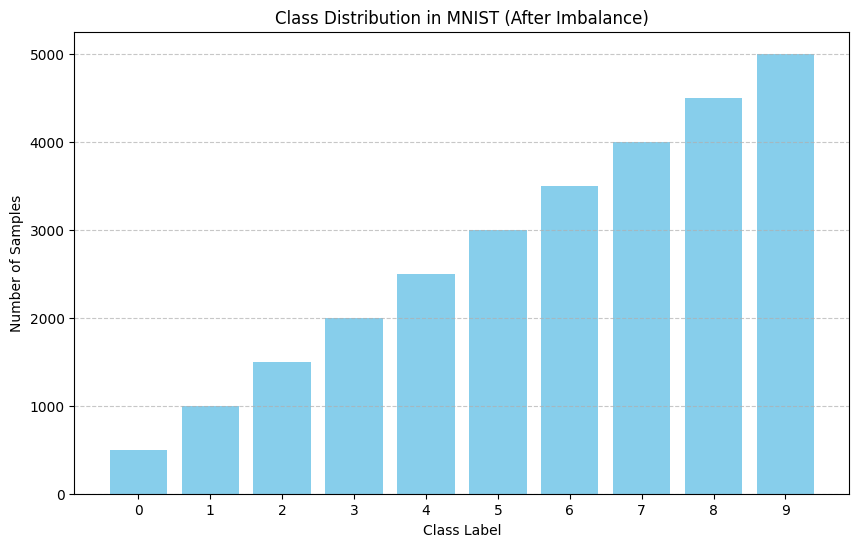

In [76]:
import matplotlib.pyplot as plt

unique_classes, class_counts = np.unique(y_train, return_counts=True)

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in MNIST (After Imbalance)')
plt.xticks(unique_classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Handle Unbalanced data
### UpSampling for class from 0 to 4 and underSampling for others

In [77]:
new_X_train = X_train.copy()
new_y_train = y_train.copy()


In [78]:
print(new_X_train.shape)

(27500, 32, 32, 3)


In [79]:
np.where(new_y_train == 2)[0].shape


(1500,)

In [80]:
for class_label in range(4):
    indeces = np.where(new_y_train == class_label)[0]
    
    num_samples = 2500 - len(indeces)
    samples_indices = np.random.choice(indeces, size=num_samples, replace=True)
    print(new_X_train[samples_indices].shape)
    new_x = new_X_train[samples_indices].copy()
    new_X_train = np.concatenate([new_X_train , new_x])
    print(new_X_train.shape)
    
    new_y = new_y_train[samples_indices].copy()
    new_y_train = np.concatenate([new_y_train , new_y])
X_train = new_X_train.copy()
y_train = new_y_train.copy()


(2000, 32, 32, 3)
(29500, 32, 32, 3)
(1500, 32, 32, 3)
(31000, 32, 32, 3)
(1000, 32, 32, 3)
(32000, 32, 32, 3)
(500, 32, 32, 3)
(32500, 32, 32, 3)


In [81]:
[2500]*5

[2500, 2500, 2500, 2500, 2500]

In [82]:
new_X_train = X_train.copy()
new_y_train = y_train.copy()

In [83]:
filtered_indices = []
for class_label in range(5 , 10):
    indeces = np.where(new_y_train == class_label)[0]
    print('class ' , class_label , 'len ' , len(indeces))
    num_samples = len(indeces) - 2500
    print(num_samples)
    samples_indices = np.random.choice(indeces, size=num_samples, replace=False)
    
    filtered_indices.extend(samples_indices)
filtered_data = np.delete(new_X_train, filtered_indices, axis=0)
filtered_labels = np.delete(new_y_train, filtered_indices, axis=0)
X_train = filtered_data.copy()
y_train = filtered_labels.copy()

class  5 len  3000
500
class  6 len  3500
1000
class  7 len  4000
1500
class  8 len  4500
2000
class  9 len  5000
2500


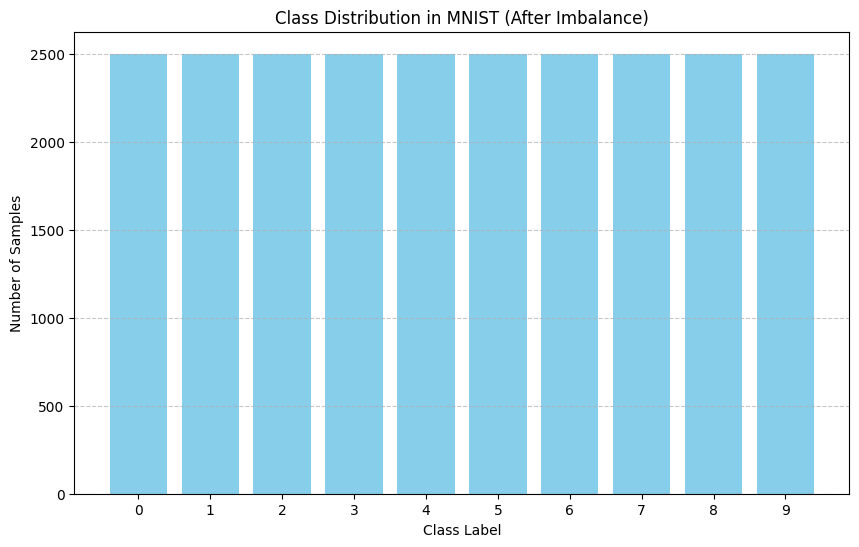

In [84]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in MNIST (After Imbalance)')
plt.xticks(unique_classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [85]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

CNN model

In [91]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense , Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical

def create_model():
    model = Sequential()
    model.add(Input((32, 32, 3)))

    # First convolutional block
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Flatten the output for the fully connected layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy' , 'recall' , 'precision' , 'f1_score'])

    # Print the model summary
    model.summary()
    return model

In [87]:
# Use predict instead of predict_proba
def predict_proba(self, X, **predict_proba_kwargs):
    return self.estimator.predict(X, **predict_proba_kwargs)
ActiveLearner.predict_proba = predict_proba

# ***Random Sampling:***

prepare data

In [92]:
#labeled data
initial_idx = slice(400)
X_initial_1 = X_train[initial_idx]
y_initial_1 = y_train[initial_idx]


#unlabeled data
X_pool_1 = np.delete(X_train, initial_idx, axis=0)
y_pool_1 = np.delete(y_train, initial_idx, axis=0)

pool_indices = np.arange(len(X_pool_1))

In [93]:
def random_sampling(classifier, X_pool_1):
    n_samples = len(X_pool_1)
    query_indices = np.random.choice(range(n_samples), size=1500, replace=False)
    return query_indices, X_pool_1[query_indices]

In [94]:
learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = random_sampling,
    X_training=X_initial_1,
    y_training=y_initial_1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

I0000 00:00:1714727592.668133     787 service.cc:145] XLA service 0x7f54e0018850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714727592.668181     787 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1714727592.668185     787 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 8/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1578 - f1_score: 0.0272 - loss: 3.5866 - precision: 0.1033 - recall: 0.0450  

I0000 00:00:1714727602.810685     787 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 640ms/step - accuracy: 0.1536 - f1_score: 0.0266 - loss: 3.5558 - precision: 0.1121 - recall: 0.0496


60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.2485 - f1_score: 0.1957 - loss: 2.8832 - precision: 0.3320 - recall: 0.1806
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.3832 - f1_score: 0.3482 - loss: 2.0102 - precision: 0.4734 - recall: 0.2741
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.4647 - f1_score: 0.4437 - loss: 1.6682 - precision: 0.5585 - recall: 0.3447
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5175 - f1_score: 0.5062 - loss: 1.4306 - precision: 0.6133 - recall: 0.4051
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.5989 - f1_score: 0.5916 - loss: 1.1830 - precision: 0.6983 - recall: 0.4871
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
294/294 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.6489 - f1_score: 0.6412 - loss: 1.0239 - precision: 0.75

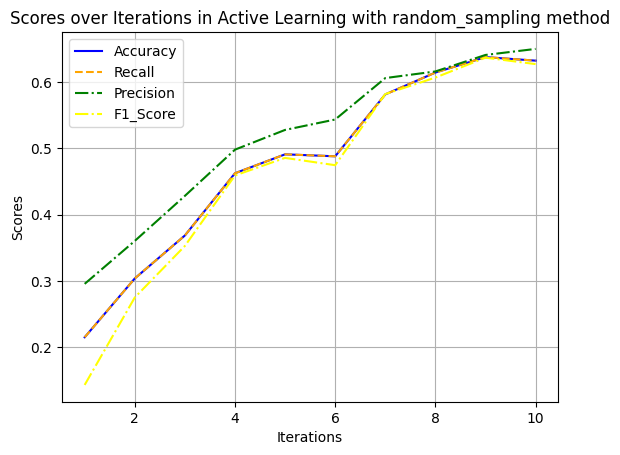

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

n_queries = 10
accuracies = [] 
recalls  = []
precisions = []
f1S = []

# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_1)
    X_query, y_query = X_pool_1[query_idx], y_pool_1[query_idx]

    
    learner.teach(X=X_query, y=y_query)
    
    X_pool_1 = np.delete(X_pool_1, query_idx, axis=0)
    y_pool_1 = np.delete(y_pool_1, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)
    y_pred = np.argmax(y_pred , axis = 1)
    
    
    acc = accuracy_score(np.argmax(y_test , axis = 1), y_pred)
    accuracies.append(acc)
    recalls.append(recall_score(np.argmax(y_test , axis = 1), y_pred, average='weighted', zero_division=1))
    precisions.append(precision_score(np.argmax(y_test , axis = 1), y_pred, average='weighted', zero_division=1))
    f1S.append(f1_score(np.argmax(y_test , axis = 1), y_pred, average='weighted', zero_division=1))

    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")
        
plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.plot(range(1, n_queries + 1), f1S, label='F1_Score', linestyle='-.', color='yellow')

plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with random_sampling method')
plt.legend()
plt.grid(True)
plt.show()

In [98]:
y_test = np.argmax(y_test , axis = 1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [99]:
y_pred = learner.predict(X_test)
y_pred = np.argmax(y_pred , axis = 1)
acc = accuracy_score(y_test, y_pred)
accuracies.append(acc)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
f1 =  f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.6327
Precision: 0.6503912272978827
Recall: 0.6327
F1-score: 0.6274700446643553


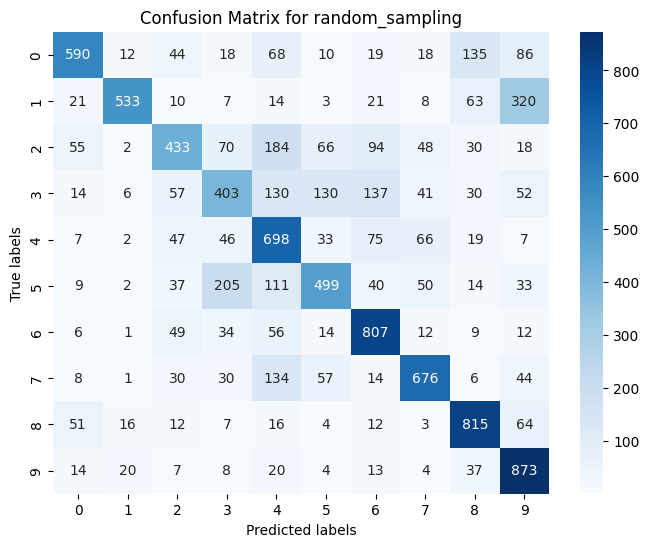

In [100]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have y_test and y_pred

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for random_sampling')
plt.show()

# ***margin_sampling:***

prepare data

In [102]:
#labeled data
initial_idx = slice(400)
X_initial_2 = X_train[initial_idx]
y_initial_2 = y_train[initial_idx]


#unlabeled data
X_pool_2 = np.delete(X_train, initial_idx, axis=0)
y_pool_2 = np.delete(y_train, initial_idx, axis=0)

In [103]:
learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = margin_sampling,
    X_training=X_initial_2,
    y_training=y_initial_2
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 523ms/step - accuracy: 0.1588 - f1_score: 0.0274 - loss: 3.6104 - precision: 0.1750 - recall: 0.0655


769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.2596 - f1_score: 0.2088 - loss: 2.8305 - precision: 0.3345 - recall: 0.1686
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.4056 - f1_score: 0.3729 - loss: 2.0223 - precision: 0.5030 - recall: 0.2948
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.4396 - f1_score: 0.4314 - loss: 1.8361 - precision: 0.5321 - recall: 0.3204
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4644 - f1_score: 0.4664 - loss: 1.6152 - precision: 0.5738 - recall: 0.3512
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.5662 - f1_score: 0.5668 - los

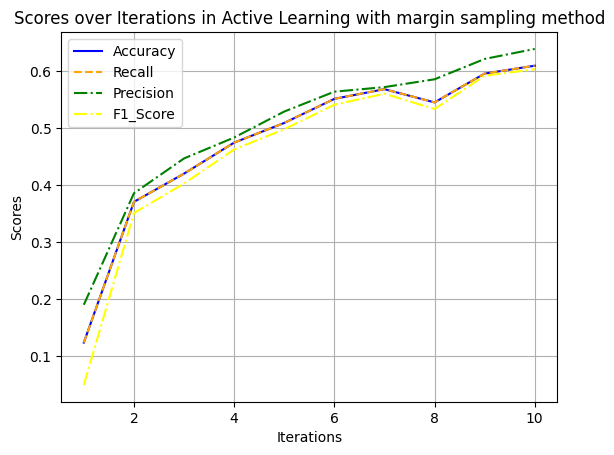

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
n_queries = 10
accuracies = [] 
recalls  = []
precisions = []
f1S = []

# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_2, n_instances=1500)
    X_query, y_query = X_pool_2[query_idx], y_pool_2[query_idx]

    
    learner.teach(X=X_query, y=y_query)
    
    X_pool_2 = np.delete(X_pool_2, query_idx, axis=0)
    y_pool_2 = np.delete(y_pool_2, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)
    y_pred = np.argmax(y_pred , axis = 1)
    
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    recalls.append(recall_score(y_test, y_pred, average='weighted', zero_division=1))
    precisions.append(precision_score(y_test, y_pred, average='weighted', zero_division=1))
    f1S.append(f1_score(y_test, y_pred, average='weighted', zero_division=1))

    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")
        
plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.plot(range(1, n_queries + 1), f1S, label='F1_Score', linestyle='-.', color='yellow')

plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with margin sampling method')
plt.legend()
plt.grid(True)
plt.show()

In [105]:
y_pred = learner.predict(X_test)
y_pred = np.argmax(y_pred , axis = 1)
acc = accuracy_score(y_test, y_pred)
accuracies.append(acc)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
f1 =  f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.6095
Precision: 0.6389160284611102
Recall: 0.6095
F1-score: 0.6032990276834377


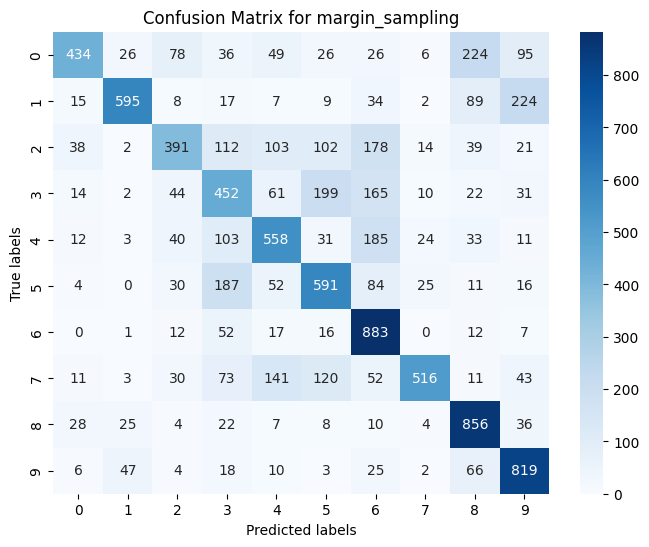

In [106]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for margin_sampling')
plt.show()

# ***entropy_sampling:***

prepare data

In [107]:
#labeled data
initial_idx = slice(400)
X_initial_3 = X_train[initial_idx]
y_initial_3 = y_train[initial_idx]


#unlabeled data
X_pool_3 = np.delete(X_train, initial_idx, axis=0)
y_pool_3 = np.delete(y_train, initial_idx, axis=0)

In [108]:
learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = entropy_sampling,
    X_training=X_initial_3,
    y_training=y_initial_3
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 536ms/step - accuracy: 0.1228 - f1_score: 0.0217 - loss: 3.4738 - precision: 0.1226 - recall: 0.0543   


769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.2815 - f1_score: 0.2190 - loss: 2.6246 - precision: 0.3932 - recall: 0.2006 
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.4011 - f1_score: 0.3724 - loss: 1.8999 - precision: 0.5169 - recall: 0.2947
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.4701 - f1_score: 0.4706 - loss: 1.6152 - precision: 0.6090 - recall: 0.3355
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4815 - f1_score: 0.4809 - loss: 1.5483 - precision: 0.6132 - recall: 0.3552
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.5429 - f1_score: 0.5366 - lo

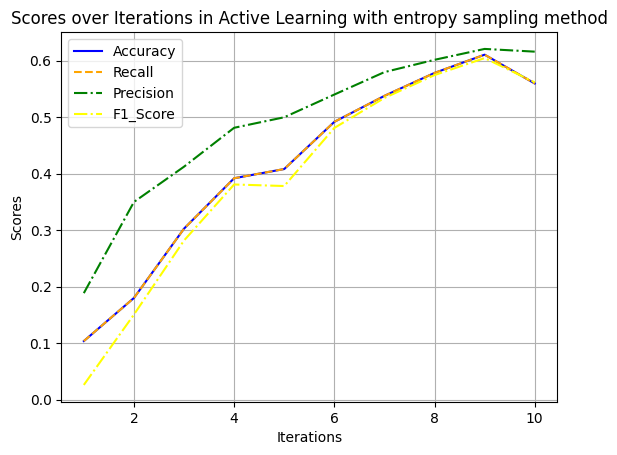

In [109]:
n_queries = 10
accuracies = [] 
recalls  = []
precisions = []
f1S = []

# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_3, n_instances=1500)
    X_query, y_query = X_pool_3[query_idx], y_pool_3[query_idx]

    
    learner.teach(X=X_query, y=y_query)
    
    X_pool_3 = np.delete(X_pool_3, query_idx, axis=0)
    y_pool_3 = np.delete(y_pool_3, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)
    y_pred = np.argmax(y_pred , axis = 1)
    
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    recalls.append(recall_score(y_test, y_pred, average='weighted', zero_division=1))
    precisions.append(precision_score(y_test, y_pred, average='weighted', zero_division=1))
    f1S.append(f1_score(y_test, y_pred, average='weighted', zero_division=1))

    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")
        
plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.plot(range(1, n_queries + 1), f1S, label='F1_Score', linestyle='-.', color='yellow')
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with entropy sampling method')
plt.legend()
plt.grid(True)

plt.show()

In [110]:
y_pred = learner.predict(X_test)
y_pred = np.argmax(y_pred , axis = 1)
acc = accuracy_score(y_test, y_pred)
accuracies.append(acc)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
f1 =  f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.5595
Precision: 0.6158443936559042
Recall: 0.5595
F1-score: 0.5615351457598418


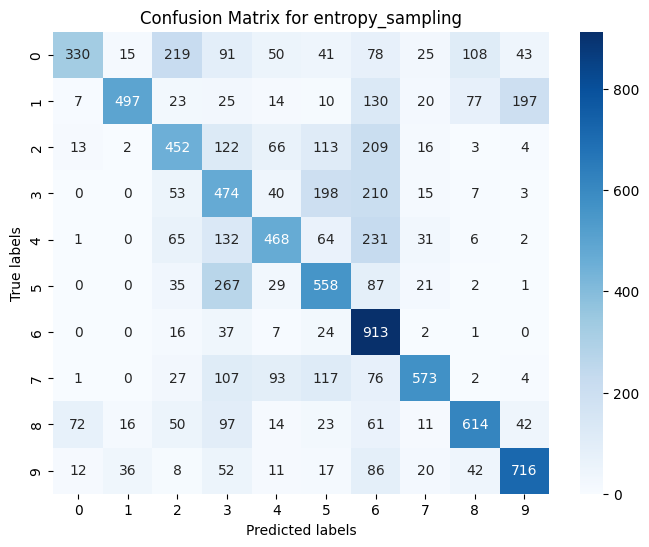

In [111]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for entropy_sampling')
plt.show()

# ***uncertainty_sampling (Least Confidence Sampling):***

prepare data

In [112]:
#labeled data
initial_idx = slice(400)
X_initial_4 = X_train[initial_idx]
y_initial_4 = y_train[initial_idx]


#unlabeled data
X_pool_4 = np.delete(X_train, initial_idx, axis=0)
y_pool_4 = np.delete(y_train, initial_idx, axis=0)

In [113]:
def least_confidence_sampling(classifier, X_pool):
    n_instances = 1500
    uncertainties = classifier.predict_proba(X_pool).max(axis=1)
    query_idx = np.argsort(uncertainties)[:n_instances]  # Sort uncertainties and select indices of least confident instances
    return query_idx

In [114]:
from modAL.disagreement import vote_entropy_sampling

learner = ActiveLearner(
    estimator=create_model(),
    query_strategy = uncertainty_sampling,
    X_training=X_initial_4,
    y_training=y_initial_4
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 536ms/step - accuracy: 0.1198 - f1_score: 0.0214 - loss: 3.6133 - precision: 0.1501 - recall: 0.0610


769/769 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.2639 - f1_score: 0.2062 - loss: 2.6972 - precision: 0.3785 - recall: 0.1727
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
722/722 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.3991 - f1_score: 0.3623 - loss: 1.8845 - precision: 0.5332 - recall: 0.2981
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.4467 - f1_score: 0.4401 - loss: 1.7770 - precision: 0.5424 - recall: 0.3206
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
629/629 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4363 - f1_score: 0.4377 - loss: 1.7311 - precision: 0.5379 - recall: 0.2933
1500
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5168 - f1_score: 0.5289 - los

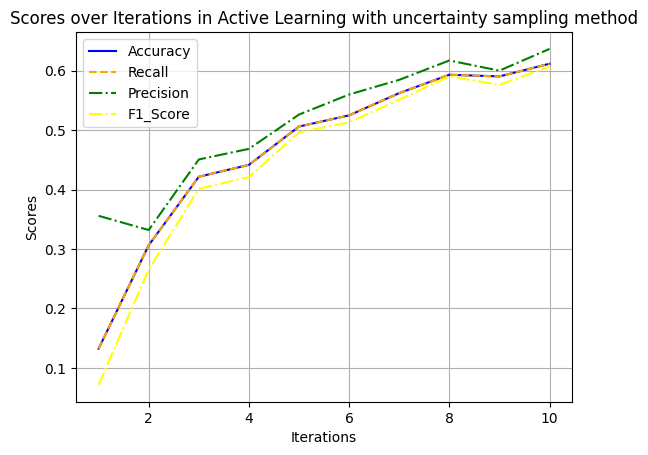

In [115]:
n_queries = 10
accuracies = [] 
recalls  = []
precisions = []
f1S = []

# Active learning loop
for _ in range(n_queries):
    query_idx, query_instance = learner.query(X_pool_4, n_instances=1500)
    X_query, y_query = X_pool_4[query_idx], y_pool_4[query_idx]

    
    learner.teach(X=X_query, y=y_query)
    
    X_pool_4 = np.delete(X_pool_4, query_idx, axis=0)
    y_pool_4 = np.delete(y_pool_4, query_idx, axis=0)
    print(len(X_query))
    y_pred = learner.predict(X_test)
    y_pred = np.argmax(y_pred , axis = 1)
    
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    recalls.append(recall_score(y_test, y_pred, average='weighted', zero_division=1))
    precisions.append(precision_score(y_test, y_pred, average='weighted', zero_division=1))
    f1S.append(f1_score(y_test, y_pred, average='weighted', zero_division=1))

    # Evaluate the model periodically
    if (_ + 1) % 10 == 0:
        print(f"Query {_+1}, Accuracy: {acc}")
        
plt.plot(range(1, n_queries + 1), accuracies, label='Accuracy', linestyle='-', color='blue')
plt.plot(range(1, n_queries + 1), recalls, label='Recall', linestyle='--', color='orange')
plt.plot(range(1, n_queries + 1), precisions, label='Precision', linestyle='-.', color='green')
plt.plot(range(1, n_queries + 1), f1S, label='F1_Score', linestyle='-.', color='yellow')

plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title('Scores over Iterations in Active Learning with uncertainty sampling method')
plt.legend()
plt.grid(True)

plt.show()

In [116]:
y_pred = learner.predict(X_test)
y_pred = np.argmax(y_pred , axis = 1)
acc = accuracy_score(y_test, y_pred)
accuracies.append(acc)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
f1 =  f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.6116
Precision: 0.6365445767063206
Recall: 0.6116
F1-score: 0.6066223040966088


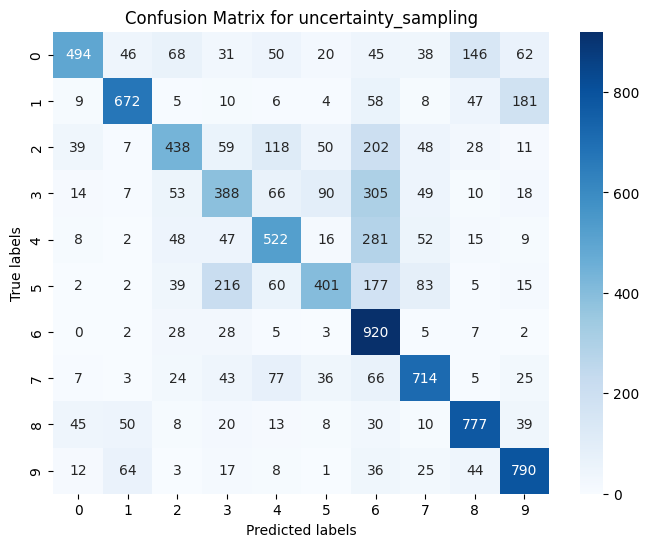

In [117]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have y_test and y_pred

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for uncertainty_sampling')
plt.show()

# ***passive learning: ***

In [118]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = create_model()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,350,826 (12.78 MB)

 Trainable params: 3,349,418 (12.78 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [120]:
# Train the model
history = model.fit(x_train, y_train, epochs=50)


Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.3986 - f1_score: 0.3969 - loss: 1.9555 - precision: 0.4852 - recall: 0.2883
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6488 - f1_score: 0.6470 - loss: 0.9984 - precision: 0.7558 - recall: 0.5501
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7083 - f1_score: 0.7077 - loss: 0.8332 - precision: 0.7963 - recall: 0.6268
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7374 - f1_score: 0.7361 - loss: 0.7444 - precision: 0.8157 - recall: 0.6677
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7672 - f1_score: 0.7664 - loss: 0.6708 - precision: 0.8335 - recall: 0.7044
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7848 - f1_score: 0.7840 - loss: 0.6146 - precision: 0.8446 - recall: 0.7293
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8038 - f1_score: 0.8032 - loss: 0.5612 - precision: 0.8542 - recall

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred , axis = 1)
y_test = np.argmax(y_test , axis = 1)


In [125]:

acc = accuracy_score(y_test, y_pred)
accuracies.append(acc)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
f1 =  f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.2913
Precision: 0.5498725202703386
Recall: 0.2913
F1-score: 0.20998432289594457


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 800x800 with 0 Axes>

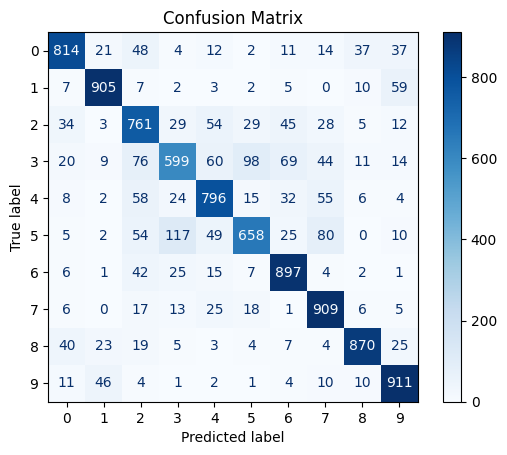

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [130]:
np.sum(y_test == y_pred)

8120

In [131]:
np.sum(y_test != y_pred)


1880